## Advanced Box Score Calculations
Author: Akshay Easwaran <akeaswaran@me.com>

---
Based on work by ESPN's Bill Connelly, Football Outsiders, and Football Study Hall

Data from CollegeFootballData.com

Useful Resources for Stat Definitions:
- Football Study Hall website: https://www.footballstudyhall.com/
- Football Study Hall book: https://www.amazon.com/Study-Hall-College-Football-Stories/dp/1484989961
- Football Outsiders: https://www.footballoutsiders.com/info/glossary
- Example Advanced Box Score: https://twitter.com/ESPN_BillC/status/1176572006969597954/photo/1

**How to use this Notebook**

1. Dump game, play by play, and drive data for an entire season from CollegeFootballData.com.
2. Change the file names in the next cell to match where your data files are located.
3. Change the away and home team names appropriately.
4. Hit Cell > Run All Cells.

In [1]:
# import pandas as pd

# base_drives = pd.read_json('data/drives/drive-data-national.json')
# base_drives.drop(['offense_conference','start_time','end_time','defense_conference','elapsed','start_period','end_period'], axis = 1, inplace=True) 
# base_drives = base_drives[
#     ~base_drives.drive_result.isin(['Uncategorized'])
# ]

# games = pd.read_json('data/games/game-data-national.json')

# selected_team = 'National'

In [2]:
# # Data Cleaning
# # Fix the bad yard line markers for away teams
# drives = pd.merge(base_drives, games[['id','away_team','home_team']], left_on='game_id', right_on='id', how='right')
# drives.rename(columns={'id_x':'drive_id'}, inplace=True)
# drives.drop(['id_y'], axis = 1, inplace=True)
# drives.dropna(inplace=True)
# drives.loc[
#     drives.offense == drives.away_team, ['start_yardline']
# ] = 100 - drives.start_yardline
# drives.loc[
#     drives.offense == drives.away_team, ['end_yardline']
# ] = 100 - drives.end_yardline

# print("Total Drives:", len(drives))
# # drives

In [3]:
# print(selected_team, "Drives:", len(drives))

# print(selected_team, "Avg Starting Field Position:", sum(drives.start_yardline) / len(drives))
# print(selected_team, "Mdn Starting Field Position:", drives.start_yardline.median())
# print("")

# drives['yards_per_play'] = drives.apply(lambda x: (x.yards / x.plays) if (x.plays > 0) else 0, axis=1)
# print(selected_team, "Avg Yards per Play:", drives.yards_per_play.mean())
# print(selected_team, "Mdn Yards per Play:", drives.yards_per_play.median())

# print("")
# print(selected_team, "Avg Plays per Drive:", drives.plays.mean())
# print(selected_team, "Mdn Plays per Drive:", drives.plays.median())

# print("")
# print(selected_team, "Avg Yards per Drive:", drives.yards.mean())
# print(selected_team, "Mdn Yards per Drive:", drives.yards.median())

In [4]:
# %matplotlib inline

# import matplotlib.pyplot as plt

# fig, ax = plt.subplots(1, 1,figsize=(12,8))
# ax.hist(drives.yards, bins=[-20,-10,0,10,20,30,40,50,60,70,80,90,100]);
# ax.set_ylabel("Frequency");
# ax.set_xlabel("Drive Yardage");

In [5]:
# fig, ax = plt.subplots(1, 1,figsize=(12,8))
# ax.scatter(drives.start_yardline, drives.yards_per_play);
# ax.set_ylabel("yards per play");
# ax.set_xlabel("Start Position");

In [6]:
# pbp_data = pd.read_json('data/pbp/pbp-data-national.json')
# # Eliminate garbage time plays
# # garbage_time_data = pbp_data[
# #     (pbp_data.down == 0)
# #     | ((abs(pbp_data.offense_score - pbp_data.defense_score) >= 38) & (pbp_data.period == 2))
# #     | ((abs(pbp_data.offense_score - pbp_data.defense_score) >= 28) & (pbp_data.period == 3))
# #     | ((abs(pbp_data.offense_score - pbp_data.defense_score) >= 22) & (pbp_data.period == 4))
# # ]

# print("Total Plays:", len(pbp_data))
# # print("Garbage Time Plays:", len(garbage_time_data))
# # pbp_data.drop(garbage_time_data.index, inplace=True)
# print("Non-Garbage Time Plays:", len(pbp_data))

# # Drop some unnecessary columns
# pbp_data.drop(['offense_conference','defense_conference','clock'], axis = 1, inplace=True) 
# # Ignore some types of plays cause they're special teams and weird
# ignore_types = ["Defensive 2pt Conversion","Blocked Field Goal","Blocked Punt","Missed Field Goal Return","Blocked Punt Touchdown","Missed Field Goal Return Touchdown","Extra Point Missed","Extra Point Good","Timeout","End of Half","End of Game","Uncategorized","Penalty","Kickoff","Kickoff Return (Offense)","Kickoff Return Touchdown","Punt", "Field Goal Good","Field Goal Missed","Safety"]
# pbp_data = pbp_data[~(pbp_data.play_type.isin(ignore_types))]
# print("Total clean plays:", len(pbp_data))

In [7]:
# import numpy as np

# pbp_data.distance = pbp_data.distance.astype(float)

# bad_types = ["Interception","Pass Interception Return","Interception Return Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']

# def is_successful(down, distance, yards_gained, play_type):
#     if (play_type in bad_types):
#         return False 
#     if ((down == 1) & (yards_gained >= (0.5 * distance))):
#         return True
#     elif ((down == 2)) & (yards_gained >= (0.7 * distance)):
#         return True
#     elif (((down == 3) | (down == 4)) & (yards_gained >= distance)):
#         return True
#     else:
#         return False
    
# pbp_data['play_successful'] = np.vectorize(is_successful)(pbp_data.down, pbp_data.distance, pbp_data.yards_gained, pbp_data.play_type)
# pbp_data.play_successful.value_counts()

# def is_explosive(yards_gained):
#     if (yards_gained >= 15):
#         return True
#     else:
#         return False
    
# pbp_data['play_explosive'] = np.vectorize(is_explosive)(pbp_data.yards_gained)

In [8]:
# pass_types = ["Pass Reception","Pass Incompletion","Passing Touchdown","Interception","Pass Interception Return","Interception Return Touchdown"]
# rush_types = ["Rush","Rushing Touchdown",'Fumble Recovery (Opponent)','Sack','Fumble Return Touchdown']

# print("Offensive Success Rates")
# base_overall = len(pbp_data[(pbp_data.play_successful == True)]) / len(pbp_data)
# print("Overall:",base_overall)
# base_passing = len(pbp_data[(pbp_data.play_successful == True) & (pbp_data.play_type.isin(pass_types))]) / len(pbp_data[(pbp_data.play_type.isin(pass_types))])
# print("Passing:",base_passing)
# base_rushing = len(pbp_data[(pbp_data.play_successful == True) & (pbp_data.play_type.isin(rush_types))]) / len(pbp_data[(pbp_data.play_type.isin(rush_types))])
# print("Rushing:",base_rushing)
# print("")


# print("Offensive Explosiveness Rates")
# base_exp_overall = len(pbp_data[(pbp_data.play_explosive == True)]) / len(pbp_data)
# print("Overall:",base_exp_overall)
# base_exp_passing = len(pbp_data[(pbp_data.play_explosive == True) & (pbp_data.play_type.isin(pass_types))]) / len(pbp_data[(pbp_data.play_type.isin(pass_types))])
# print("Passing:",base_exp_passing)
# base_exp_rushing = len(pbp_data[(pbp_data.play_explosive == True) & (pbp_data.play_type.isin(rush_types))]) / len(pbp_data[(pbp_data.play_type.isin(rush_types))])
# print("Rushing:",base_exp_rushing)
# print("")

In [9]:
# # SR+
# selected_team = 'Georgia Tech'
# selected_team_data = pbp_data[
#     (pbp_data.offense == selected_team)
#     | (pbp_data.defense == selected_team)
# ]

# overall = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.offense == selected_team)]) / len(selected_team_data[(selected_team_data.offense == selected_team)])
# passing = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.offense == selected_team) & (selected_team_data.play_type.isin(pass_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(pass_types)) & (selected_team_data.offense == selected_team)])
# rushing = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.offense == selected_team) & (selected_team_data.play_type.isin(rush_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(rush_types)) & (selected_team_data.offense == selected_team)])

# exp_overall = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.offense == selected_team)]) / len(selected_team_data[(selected_team_data.offense == selected_team)])
# exp_passing = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.offense == selected_team) & (selected_team_data.play_type.isin(pass_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(pass_types)) & (selected_team_data.offense == selected_team)])
# exp_rushing = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.offense == selected_team) & (selected_team_data.play_type.isin(rush_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(rush_types)) & (selected_team_data.offense == selected_team)])

# def_overall = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.defense == selected_team)]) / len(selected_team_data[(selected_team_data.defense == selected_team)])
# def_passing = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.defense == selected_team) & (selected_team_data.play_type.isin(pass_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(pass_types)) & (selected_team_data.defense == selected_team)])
# def_rushing = len(selected_team_data[(selected_team_data.play_successful == True) & (selected_team_data.defense == selected_team) & (selected_team_data.play_type.isin(rush_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(rush_types)) & (selected_team_data.defense == selected_team)])

# exp_def_overall = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.defense == selected_team)]) / len(selected_team_data[(selected_team_data.defense == selected_team)])
# exp_def_passing = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.defense == selected_team) & (selected_team_data.play_type.isin(pass_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(pass_types)) & (selected_team_data.defense == selected_team)])
# exp_def_rushing = len(selected_team_data[(selected_team_data.play_explosive == True) & (selected_team_data.defense == selected_team) & (selected_team_data.play_type.isin(rush_types))]) / len(selected_team_data[(selected_team_data.play_type.isin(rush_types)) & (selected_team_data.defense == selected_team)])


# def plus_adj(base, comp):
#     diff = comp - base
#     pct = (diff / base) * 100
#     return 100 + pct

# print(selected_team,"SR+ Stats")
# print("")

# print("Offensive (higher + is better)")
# print("Overall Off SR:",overall)
# print("Overall Off SR+:",plus_adj(base_overall, overall))
# print("")
# print("Passing Off SR:",passing)
# print("Passing Off SR+:",plus_adj(base_passing, passing))
# print("")
# print("Rushing Off SR:",rushing)
# print("Rushing Off SR+:",plus_adj(base_rushing, rushing))

# print("")

# print("Overall Off ER:",exp_overall)
# print("Overall Off ER+:",plus_adj(base_exp_overall, exp_overall))
# print("")
# print("Passing Off ER:",exp_passing)
# print("Passing Off ER+:",plus_adj(base_exp_passing, exp_passing))
# print("")
# print("Rushing Off ER:",exp_rushing)
# print("Rushing Off ER+:",plus_adj(base_exp_rushing, exp_rushing))

# print("")

# print("Defensive (lower + is better)")
# print("Overall Def SR:",def_overall)
# print("Overall Def SR+:",plus_adj(base_overall, def_overall))
# print("")
# print("Passing Def SR:",def_passing)
# print("Passing Def SR+:",plus_adj(base_passing, def_passing))
# print("")
# print("Rushing Def SR:",def_rushing)
# print("Rushing Def SR+:",plus_adj(base_rushing, def_rushing))

# print("")

# print("Overall Def ER:",exp_def_overall)
# print("Overall Def ER+:",plus_adj(base_exp_overall, exp_def_overall))
# print("")
# print("Passing Def ER:",exp_def_passing)
# print("Passing Def ER+:",plus_adj(base_exp_passing, exp_def_passing))
# print("")
# print("Rushing Def ER:",exp_def_rushing)
# print("Rushing Def ER+:",plus_adj(base_exp_rushing, exp_def_rushing))

In [10]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def retrieveCfbDataFile(endpoint, year):
    return pd.read_csv(f"data/{endpoint}/{year}.csv", encoding='latin-1')


pbp_data = pd.DataFrame()
for i in range(2012, 2020):    
    plys = retrieveCfbDataFile('pbp',i)
    plys['year'] = i
    pbp_data = pbp_data.append(plys, sort=False)
pbp_data.reset_index(inplace=True, drop=True)

pbp_data.loc[
    pbp_data.offense == pbp_data.away, ['yard_line']
] = 100 - pbp_data.yard_line

# for one reason or antoher, these punts have the right yard lines we want assigned already, but get flipped since the offense is away (or if it's 25798 for ??? reasons).
# we flip them back here
bad_punt_indices = [177146,
 315753,
 336962,
 383730,
 383797,
 385269,
 452757,
 455114,
 455125,
 455801,
 508318,
 512113,
 512125,
 512145,
 513351,
 513406,
 704982,
 818273,
 818285,
 818336,
 919364,
 919378,
 921054,
 985503,
 988349,
 1087559,
 1087579,
 1165630,
 1165638,
 1165688]

pbp_data.loc[
    pbp_data.index.isin(bad_punt_indices), ['yard_line']
] = 100 - pbp_data.yard_line

# remove Michael Dickson's punt 471732 from the end of the 1st quarter in OU/TX 2015 (https://www.espn.com/college-football/playbyplay?gameId=400763434)
# the yardline is miscalculated
pbp_data.drop(471732, inplace=True)

pbp_data.dropna(subset=['play_text'], inplace=True)
pbp_data.head()

,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,drive_id,...,clock.minutes,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year
0,322430009013,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,7,0,32243000901,...,11,26,35,-1,-1,15,Kickoff,Alex Garoutte kickoff for 65 yards returned by...,NaN,2012
1,322430009007,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,32243000901,...,12,27,72,1,10,0,Pass Incompletion,Taylor Kelly pass incomplete to Chris Coyle.,-0.512082,2012
2,322430009008,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,32243000901,...,12,18,72,2,10,3,Pass Completion,Taylor Kelly pass complete to D.J. Foster for ...,-0.220409,2012
3,322430009009,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,0,0,32243000901,...,11,45,75,3,7,16,Pass Completion,Taylor Kelly pass complete to Chris Coyle for ...,1.072268,2012
4,322430009011,Arizona State,Pac-12,Northern Arizona,NaN,Arizona State,Northern Arizona,6,0,32243000901,...,11,26,91,1,9,9,Rush,Cameron Marshall rush for 9 yards for a TOUCHD...,NaN,2012


In [11]:
pbp_data[(pbp_data.drive_id == 32243000902) & (pbp_data.offense == pbp_data.away)].sort_values(by="id",ascending=True)

,id,offense,offense_conference,defense,defense_conference,home,away,offense_score,defense_score,drive_id,...,clock.minutes,clock.seconds,yard_line,down,distance,yards_gained,play_type,play_text,ppa,year
15,322430009014,Northern Arizona,NaN,Arizona State,Pac-12,Arizona State,Northern Arizona,0,7,32243000902,...,11,13,15,1,10,11,Rush,Zach Bauman rush for 11 yards to the NoArz 26 ...,0.614185,2012
14,322430009015,Northern Arizona,NaN,Arizona State,Pac-12,Arizona State,Northern Arizona,0,7,32243000902,...,10,49,26,1,10,0,Rush,Cary Grossart rush for no gain to the NoArz 26.,-0.734248,2012
16,322430009016,Northern Arizona,NaN,Arizona State,Pac-12,Arizona State,Northern Arizona,0,7,32243000902,...,10,23,26,2,10,0,Penalty,NORTHRN ARIZONA penalty 13 yard Illegal Block ...,NaN,2012
13,322430009017,Northern Arizona,NaN,Arizona State,Pac-12,Arizona State,Northern Arizona,0,7,32243000902,...,9,55,13,2,23,2,Rush,Zach Bauman rush for 2 yards to the NoArz 15.,-0.026373,2012
11,322430009018,Northern Arizona,NaN,Arizona State,Pac-12,Arizona State,Northern Arizona,0,7,32243000902,...,9,25,15,3,21,0,Timeout,"Timeout ARIZONA STATE, clock 9:25.",NaN,2012
12,322430009019,Northern Arizona,NaN,Arizona State,Pac-12,Arizona State,Northern Arizona,0,7,32243000902,...,9,14,15,3,21,5,Pass Completion,Cary Grossart pass complete to Zach Bauman for...,0.002419,2012
17,322430009020,Northern Arizona,NaN,Arizona State,Pac-12,Arizona State,Northern Arizona,0,7,32243000902,...,8,36,20,4,16,0,Punt,"Andy Wilder punt for 61 yards, downed at the A...",NaN,2012


In [12]:
len(pbp_data[pbp_data.play_text.isna() == True])

0

In [13]:
kickoff_plays = pbp_data[pbp_data.play_type.str.contains("Kickoff") & ~(pbp_data.play_text.str.contains("on-side"))]
tmp = pd.DataFrame(data=kickoff_plays.play_text.str.extract('kickoff for (\d+) ya*r*ds', expand=True).astype(float))

def determine_kick_return(row):
    if "touchback" in row.PlayText:
        return 25
    else:
        return kickoff_plays.yards_gained[row.Index]

kickoff_distance = pd.DataFrame()
kickoff_distance["Index"] = tmp.index
kickoff_distance["Season"] = kickoff_distance.apply(lambda x: kickoff_plays.year[x.Index],axis=1)
kickoff_distance["KickingTeam"] = kickoff_distance.apply(lambda x: kickoff_plays.offense[x.Index],axis=1)
kickoff_distance["Yardline"] = kickoff_distance.apply(lambda x: 0 if (x.Index == None) else kickoff_plays.yard_line[x.Index],axis=1)
kickoff_distance["PlayText"] = kickoff_distance.apply(lambda x: kickoff_plays.play_text[x.Index],axis=1)
kickoff_distance["Distance"] = tmp.values
kickoff_distance["Return"] = kickoff_distance.apply(lambda x: determine_kick_return(x),axis=1)
kickoff_distance["Net"] = kickoff_distance.Distance - kickoff_distance.Return
kickoff_distance['SuccessfulKickoff'] = kickoff_distance.Net.apply(lambda x: x >= 40)
kickoff_distance['SuccessfulKickoffReturn'] = kickoff_distance.Return.apply(lambda x: x >= 24)
kickoff_distance.head(10)
print(kickoff_distance.SuccessfulKickoff.value_counts(normalize=True))
print(kickoff_distance.SuccessfulKickoffReturn.value_counts(normalize=True))

True     0.727252
False    0.272748
Name: SuccessfulKickoff, dtype: float64
True     0.560621
False    0.439379
Name: SuccessfulKickoffReturn, dtype: float64


In [14]:
print("AVG Kick Distance:", kickoff_distance.Distance.mean())
print("AVG Kick Return:", kickoff_distance.Return.mean())

AVG Kick Distance: 60.856765470323396
AVG Kick Return: 21.354803076007986


In [15]:
print(kickoff_distance[(kickoff_distance.KickingTeam == 'Georgia Tech') & (kickoff_distance.Season == 2019)].SuccessfulKickoff.value_counts(normalize=True))
print(kickoff_distance[(kickoff_distance.KickingTeam == 'Georgia Tech') & (kickoff_distance.Season == 2019)].SuccessfulKickoffReturn.value_counts(normalize=True))

True     0.621622
False    0.378378
Name: SuccessfulKickoff, dtype: float64
False    0.594595
True     0.405405
Name: SuccessfulKickoffReturn, dtype: float64


In [16]:
# Filtering all kickoffs by:
# team: GT
# year: 2019
# kickoff depth: yardline + distance >= 100
# no return
print("Total Kickoffs:", len(kickoff_distance[(kickoff_distance.KickingTeam == 'Georgia Tech') & (kickoff_distance.Season == 2019)]))
kickoff_distance[(kickoff_distance.KickingTeam == 'Georgia Tech') & (kickoff_distance.Season == 2019) & (kickoff_distance.Yardline + kickoff_distance.Distance >= 100) & (kickoff_distance.Return == 25)]

Total Kickoffs: 37


,Index,Season,KickingTeam,Yardline,PlayText,Distance,Return,Net,SuccessfulKickoff,SuccessfulKickoffReturn
62656,1077543,2019,Georgia Tech,35,Brenton King kickoff for 65 yds for a touchback,65.0,25,40.0,True,True
62898,1081379,2019,Georgia Tech,35,Brenton King kickoff for 65 yds for a touchback,65.0,25,40.0,True,True
62899,1081413,2019,Georgia Tech,35,"Brenton King kickoff for 65 yds , Tanner Ingle...",65.0,25,40.0,True,True
67182,1152328,2019,Georgia Tech,35,Wesley Wells kickoff for 65 yds for a touchback,65.0,25,40.0,True,True
67183,1152334,2019,Georgia Tech,35,Wesley Wells kickoff for 65 yds for a touchback,65.0,25,40.0,True,True
67342,1155315,2019,Georgia Tech,35,Brenton King kickoff for 65 yds for a touchback,65.0,25,40.0,True,True


In [17]:
# Natural Touchback rate
print("Total Kickoffs:", len(kickoff_distance[(kickoff_distance.Season == 2019)]))
print("Natural Touchbacks:", len(kickoff_distance[(kickoff_distance.Season == 2019) & (kickoff_distance.Yardline + kickoff_distance.Distance >= 100) & (kickoff_distance.Return == 25)]))

Total Kickoffs: 9213
Natural Touchbacks: 4061


In [18]:
team_kicks = kickoff_distance.copy().groupby(['Season', 'KickingTeam'])

def verify_division(a, b):
    if b == 0:
        return 0
    else: 
        return a / b
    
teams = retrieveCfbDataFile("teams", 2019)
list_teams = teams[teams.conference.isna() == False].school.to_list()

In [19]:
kick_ratings = team_kicks.apply(lambda x: 100 * verify_division(len(x[(x.Yardline + x.Distance >= 100) & (x.Return == 25)]),len(x)))
team_kickoffs = kick_ratings.reset_index()
team_kickoffs.columns = ["Season",'KickingTeam','NatTBRate']
team_kickoffs

team_kickoffs['Pctl'] = (1 - team_kickoffs.NatTBRate.rank(pct = True, ascending=False)) * 100
team_kickoffs[team_kickoffs.KickingTeam.isin(list_teams)].sort_values(by="NatTBRate", ascending=False)

,Season,KickingTeam,NatTBRate,Pctl
1328,2018,LSU,92.753623,97.735399
1445,2018,Virginia Tech,91.044776,97.675805
1566,2019,Missouri,90.769231,97.616210
1651,2019,UCLA,85.245902,97.497020
929,2016,New Mexico,85.185185,97.437426
1302,2018,Georgia,84.946237,97.377831
1429,2018,UAB,84.931507,97.318236
1546,2019,LSU,84.821429,97.258641
1090,2017,Georgia Southern,84.615385,97.199046
689,2015,Liberty,83.333333,97.109654


In [20]:
kick_pivot = team_kickoffs.pivot_table(values='NatTBRate', index='KickingTeam', columns='Season').reset_index()
kick_pivot#.corr()

Season,KickingTeam,2012,2013,2014,2015,2016,2017,2018,2019
0,Abilene Christian,NaN,20.000000,6.666667,0.000000,50.000000,33.333333,40.000000,0.000000
1,Air Force,41.379310,60.784314,54.929577,61.728395,51.428571,50.746269,43.939394,34.246575
2,Akron,37.777778,22.222222,19.298246,27.586207,12.307692,18.965517,59.615385,40.625000
3,Alabama,44.943820,26.250000,30.681818,51.898734,52.525253,47.191011,41.284404,36.633663
4,Alabama A&M,0.000000,0.000000,66.666667,0.000000,0.000000,0.000000,0.000000,NaN
5,Alabama State,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000
6,Albany,NaN,0.000000,NaN,33.333333,25.000000,50.000000,33.333333,50.000000
7,Alcorn State,0.000000,50.000000,50.000000,0.000000,66.666667,0.000000,0.000000,0.000000
8,Appalachian State,50.000000,0.000000,35.064935,52.500000,64.615385,34.246575,56.962025,32.967033
9,Arizona,45.714286,46.268657,57.142857,39.506173,33.333333,66.292135,80.821918,78.688525


In [21]:
punt_plays = pbp_data[pbp_data.play_type.str.contains("Punt")]
pt_tmp = pd.DataFrame(data=punt_plays.play_text.str.extract('punt for (\d+) ya*r*ds', expand=True).astype(float))
pt_tmp.fillna(0, inplace=True)
punt_distance = pd.DataFrame(columns=["Index","Distance","Return","Net"])

def determine_punt_return(row):
    if "touchback" in row.PlayText:
        return 20
    else:
        return punt_plays.yards_gained[row.Index]

if (len(pt_tmp) > 0):
    punt_distance["Index"] = pt_tmp.index
    punt_distance["GameID"] = punt_distance.apply(lambda x: punt_plays.id[x.Index].astype(str)[0:9], axis=1)
    punt_distance["Season"] = punt_distance.apply(lambda x: punt_plays.year[x.Index],axis=1)
    punt_distance["Offense"] = punt_distance.apply(lambda x: punt_plays.offense[x.Index],axis=1)
    punt_distance["Period"] = punt_distance.apply(lambda x: punt_plays.period[x.Index], axis=1)
    punt_distance["ClockMinutes"] = punt_distance.apply(lambda x: punt_plays['clock.minutes'][x.Index],axis=1)
    punt_distance["ClockSeconds"] = punt_distance.apply(lambda x: punt_plays['clock.seconds'][x.Index],axis=1)
    punt_distance["YdsToGo"] = punt_distance.apply(lambda x: punt_plays.distance[x.Index],axis=1)
    punt_distance["ScoreMargin"] = punt_distance.apply(lambda x: punt_plays.offense_score[x.Index] - punt_plays.defense_score[x.Index],axis=1)
    punt_distance["Yardline"] = punt_distance.apply(lambda x: 0 if (x.Index == None) else punt_plays.yard_line[x.Index],axis=1)
    punt_distance["PlayText"] = punt_distance.apply(lambda x: punt_plays.play_text[x.Index],axis=1)
    punt_distance["Distance"] = pt_tmp.values
    punt_distance["Return"] = punt_distance.apply(lambda x: determine_punt_return(x),axis=1)
    punt_distance["Net"] = punt_distance.Distance - punt_distance.Return
    
punt_distance.head(10)

,Index,Distance,Return,Net,GameID,Season,Offense,Period,ClockMinutes,ClockSeconds,YdsToGo,ScoreMargin,Yardline,PlayText
0,17,61.0,0,61.0,322430009,2012,Northern Arizona,1,8,36,16,-7,20,"Andy Wilder punt for 61 yards, downed at the A..."
1,30,41.0,0,41.0,322430009,2012,Northern Arizona,1,4,32,5,-14,44,"Andy Wilder punt for 41 yards, punt out-of-bou..."
2,41,46.0,5,41.0,322430009,2012,Northern Arizona,1,0,27,16,-14,23,"Andy Wilder punt for 46 yards, returned by A.J..."
3,61,36.0,0,36.0,322430009,2012,Northern Arizona,2,9,48,14,-28,21,"Andy Wilder punt for 36 yards, fair catch by R..."
4,91,32.0,0,32.0,322430009,2012,Arizona State,2,0,9,18,42,61,"Taylor Kelly punt for 32 yards, downed at the ..."
5,101,33.0,0,33.0,322430009,2012,Northern Arizona,3,13,43,4,-42,31,"Andy Wilder punt for 33 yards, punt out-of-bou..."
6,105,47.0,18,29.0,322430009,2012,Arizona State,3,11,23,21,42,25,"Josh Hubner punt for 47 yards, returned by Aus..."
7,116,40.0,0,40.0,322430009,2012,Arizona State,3,8,13,3,36,45,"Josh Hubner punt for 40 yards, downed at the N..."
8,138,38.0,0,38.0,322430009,2012,Northern Arizona,4,14,50,16,-43,18,"Andy Wilder punt for 38 yards, downed at the A..."
9,152,39.0,8,31.0,322430009,2012,Northern Arizona,4,9,50,9,-50,26,"Andy Wilder punt for 39 yards, returned by Rob..."


In [44]:
print("AVG PUNT Distance:", punt_distance.Distance.mean())
print("AVG PUNT Return:", punt_distance.Return.mean())

AVG PUNT Distance: 41.0173340398153
AVG PUNT Return: 5.024146544546212


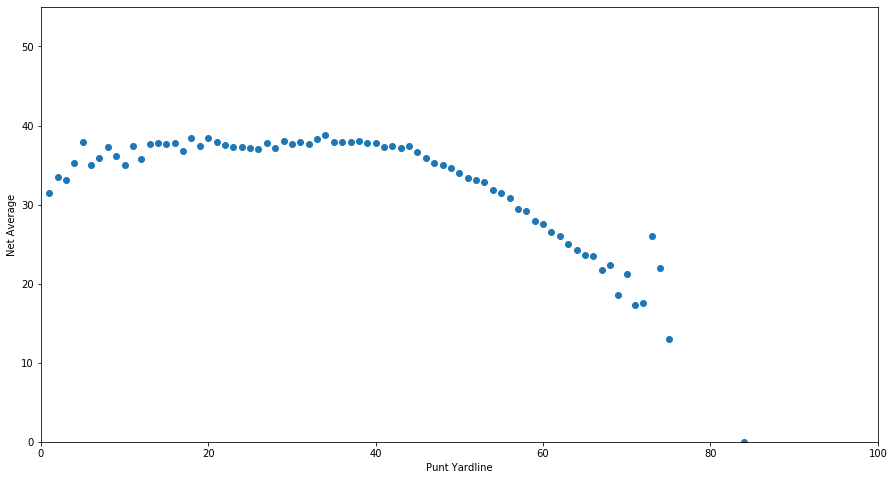

In [22]:
X_punt = punt_distance.groupby('Yardline').apply(lambda y: y['Yardline']).drop_duplicates().to_numpy()[:, np.newaxis]
y_punt = punt_distance.groupby('Yardline').apply(lambda y: y['Net'].mean()).to_numpy()
fig, ax = plt.subplots(1, 1,figsize=(15,8))
ax.scatter(X_punt, y_punt);
ax.set_ylim((0, 55))
ax.set_xlim((0, 100))
ax.set_ylabel("Net Average");
ax.set_xlabel("Punt Yardline");

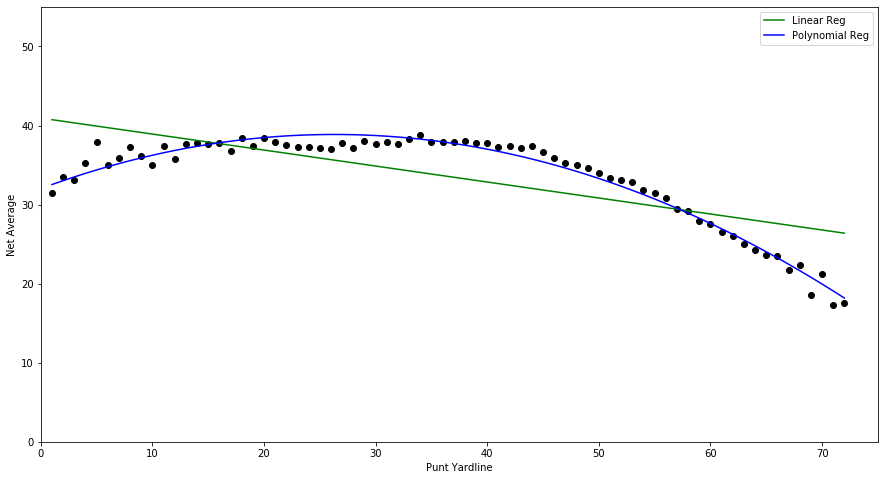

In [23]:
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression 
from sklearn.pipeline import Pipeline


base_set = punt_distance[punt_distance.Yardline <= 72.5]
X = base_set.groupby('Yardline').apply(lambda y: y.Yardline).drop_duplicates().to_numpy()[:, np.newaxis]
y = base_set.groupby('Yardline').apply(lambda y: y['Net'].mean()).to_numpy()

# print(X)

lin = LinearRegression()  
lin.fit(X, y) 

poly = PolynomialFeatures(degree = 2) 
X_poly = poly.fit_transform(X)
poly.fit(X_poly, y) 
lin2 = LinearRegression() 
lin2.fit(X_poly, y) 

# lin2 = Pipeline([('poly', PolynomialFeatures(degree=2)), ('linear', LinearRegression(fit_intercept=False))])
# lin2.fit(X_poly, y)

fig, ax = plt.subplots(1, 1,figsize=(15,8))
# Visualising the Linear Regression results 
ax.scatter(X, y, color = 'black') 
ax.set_ylim((0, 55))
ax.set_xlim((0, 75))
ax.set_ylabel("Net Average");
ax.set_xlabel("Punt Yardline");
ax.plot(X, lin.predict(X), color = 'g', label="Linear Reg") 
ax.plot(X, lin2.predict(poly.fit_transform(X)), color = 'b', label="Polynomial Reg") 
ax.legend();

In [24]:
lin2.coef_

array([ 0.        ,  0.52053388, -0.0098997 ])

In [25]:
exp_punt_net = pd.DataFrame(data={"Yardline":range(1, 101)})
exp_punt_net['ExpPuntNet'] = lin2.predict(poly.fit_transform(exp_punt_net.Yardline.to_numpy()[:, np.newaxis]))
exp_punt_net.to_csv('results/punt_sr.csv', index=False, sep=",") # only uncomment to save the file
exp_punt_net

,Yardline,ExpPuntNet
0,1,32.537211
1,2,33.028045
2,3,33.499081
3,4,33.950317
4,5,34.381753
5,6,34.793391
6,7,35.185228
7,8,35.557267
8,9,35.909506
9,10,36.241945


In [26]:
# lin2.coef_[2] + (lin2.coef_[1] * (25 ** 1)) + (lin2.coef_[0] * (25 ** 2))
# 3 - 2 * x + x ** 2 - x ** 3
# [ 3., -2.,  1., -1.]

In [27]:
punts = punt_distance.copy()
succ_punt_curve = pd.read_csv("results/punt_sr.csv", encoding="latin-1")
def is_punt_successful(ydline, net):
    return net >= succ_punt_curve[succ_punt_curve.Yardline == ydline].ExpPuntNet.to_list()[0]

def calc_punt_sharpnet(ydline, net):
    return (net / succ_punt_curve[succ_punt_curve.Yardline == ydline].ExpPuntNet.to_list()[0]) * 100

def calculate_clock(mins, secs, period):
    time = (mins * 60) + secs + (900 * (period - 3))
    return time

def calc_punt_surrender_index(row):
    fp = 0
    if (row.Yardline <= 40):
        fp = 1.0
    elif (40 < row.Yardline <= 50):
        fp = 1.1 ** (row.Yardline - 40)
    else:
        fp = 2.59 * 1.2 ** (row.Yardline - 50)
        
    first_down = 0
    if (row.YdsToGo <= 1):
        first_down = 1.0
    elif (2 <= row.YdsToGo <= 3):
        first_down = 0.8
    elif (4 <= row.YdsToGo <= 6):
        first_down = 0.6
    elif (7 <= row.YdsToGo <= 9):
        first_down = 0.4
    else:
        first_down = 0.2
        
    score = 0
    if (row.ScoreMargin > 0):
        score = 1
    elif (row.ScoreMargin == 0):
        score = 2
    elif (-8 <= row.ScoreMargin < 0):
        score = 4
    else:
        score = 3
        
    tm_f = 0    
    if (row.Period > 2) and (row.ScoreMargin <= 0):
        tm = row.ClockMinutes * 60 + row.ClockSeconds + 900 * (row.Period - 3)
        tm_f = ((tm * 0.001) ** 3) + 1
    else:
        tm_f = 1
    
    return fp * first_down * score * tm_f


punts['Successful'] = punts.apply(lambda x: is_punt_successful(x.Yardline, x.Net), axis=1)
punts["SHARPNet"] = punts.apply(lambda x: calc_punt_sharpnet(x.Yardline, x.Net), axis=1)
punts["SurrenderIndex"] = punts.apply(lambda x: calc_punt_surrender_index(x), axis=1)
# punts.sort_values(by="SurrenderIndex", ascending=False, inplace=True)
punts['SIRank'] = 1 - punts.SurrenderIndex.rank(pct = True, ascending=False)
# print(punts.Successful.value_counts(normalize=True))
punts.head(10)

,Index,Distance,Return,Net,GameID,Season,Offense,Period,ClockMinutes,ClockSeconds,YdsToGo,ScoreMargin,Yardline,PlayText,Successful,SHARPNet,SurrenderIndex,SIRank
0,17,61.0,0,61.0,322430009,2012,Northern Arizona,1,8,36,16,-7,20,"Andy Wilder punt for 61 yards, downed at the A...",True,158.534724,0.800000,0.343539
1,30,41.0,0,41.0,322430009,2012,Northern Arizona,1,4,32,5,-14,44,"Andy Wilder punt for 41 yards, punt out-of-bou...",True,114.639616,2.635380,0.710438
2,41,46.0,5,41.0,322430009,2012,Northern Arizona,1,0,27,16,-14,23,"Andy Wilder punt for 46 yards, returned by A.J...",True,105.773927,0.600000,0.243895
3,61,36.0,0,36.0,322430009,2012,Northern Arizona,2,9,48,14,-28,21,"Andy Wilder punt for 36 yards, fair catch by R...",False,93.283531,0.600000,0.243895
4,91,32.0,0,32.0,322430009,2012,Arizona State,2,0,9,18,42,61,"Taylor Kelly punt for 32 yards, downed at the ...",True,118.772051,3.848783,0.793899
5,101,33.0,0,33.0,322430009,2012,Northern Arizona,3,13,43,4,-42,31,"Andy Wilder punt for 33 yards, punt out-of-bou...",False,85.382698,2.803395,0.722315
6,105,47.0,18,29.0,322430009,2012,Arizona State,3,11,23,21,42,25,"Josh Hubner punt for 47 yards, returned by Aus...",False,74.641056,0.200000,0.035955
7,116,40.0,0,40.0,322430009,2012,Arizona State,3,8,13,3,36,45,"Josh Hubner punt for 40 yards, downed at the N...",True,112.982504,1.288408,0.506124
8,138,38.0,0,38.0,322430009,2012,Northern Arizona,4,14,50,16,-43,18,"Andy Wilder punt for 38 yards, downed at the A...",False,99.505916,4.041203,0.810438
9,152,39.0,8,31.0,322430009,2012,Northern Arizona,4,9,50,9,-50,26,"Andy Wilder punt for 39 yards, returned by Rob...",False,79.756591,5.169539,0.847498


In [28]:
punts.sort_values(by="SIRank",ascending=False).head(10)

,Index,Distance,Return,Net,GameID,Season,Offense,Period,ClockMinutes,ClockSeconds,YdsToGo,ScoreMargin,Yardline,PlayText,Successful,SHARPNet,SurrenderIndex,SIRank
38205,695256,25.0,0,25.0,400869276,2016,North Dakota,4,15,0,5,-7,65,"Austin Dussold punt for 25 yds, downed at the ...",True,104.014749,654.300955,0.999985
30434,553158,28.0,0,28.0,400763533,2015,Wisconsin,4,14,5,8,-4,67,"Drew Meyer punt for 28 yds, downed at the Iowa 5",True,124.651642,580.464728,0.999970
31814,579882,33.0,20,13.0,400787247,2015,Idaho State,4,15,0,8,-65,67,Sean Cheney punt for 33 yds for a touchback,False,57.873976,471.096688,0.999955
13035,243721,35.0,0,35.0,332992390,2013,Miami,4,10,42,2,-4,62,"Pat O'Donnell punt for 35 yards, downed at the...",True,133.357534,344.839566,0.999939
56153,1023229,26.0,0,26.0,401015033,2018,Marshall,4,13,50,19,-3,68,"Isaiah Green punt for 26 yds, fair catch by Ty...",True,120.110826,340.784779,0.999924
22622,413949,30.0,0,30.0,400548179,2014,Montana,4,15,0,4,-11,63,"Stephen Shaw punt for 30 yds, fair catch by D....",True,117.516602,340.781747,0.999909
39420,718540,22.0,0,22.0,400869472,2016,Boston College,4,13,38,9,-1,64,"Mike Knoll punt for 22 yds, fair catch by Bra'...",False,88.739806,322.996092,0.999894
22370,409007,32.0,0,32.0,400548133,2014,Akron,4,10,36,5,0,67,"Zach Paul punt for 32 yds, downed at the Ohio 1",True,142.459019,318.836932,0.999879
38392,698974,34.0,20,14.0,400869307,2016,Central Michigan,4,12,19,6,0,66,Jack Sheldon punt for 34 yds for a touchback,False,60.192462,310.460447,0.999864
6696,126891,35.0,20,15.0,323220189,2012,Kent State,4,14,6,4,0,65,Anthony Melchiori punt for 35 yards for a touc...,False,62.408850,302.763063,0.999849


In [29]:
# Finding bad punt indices where the yardline has been mislabeled
punt_plays.loc[(punt_plays.away == punt_plays.offense) & (punt_plays.yard_line >= 72.5) & (punt_plays.index.isin(punts[(punts.SIRank >= 0.99)].Index.to_list()))][['yard_line','play_text']].index.to_list()

[]

In [30]:
# top 10 most cowardly GT Punts in 2019
punts[(punts.Offense == "Georgia Tech") & (punts.Season == 2019)].sort_values(by="SIRank", ascending=False).head(10)

,Index,Distance,Return,Net,GameID,Season,Offense,Period,ClockMinutes,ClockSeconds,YdsToGo,ScoreMargin,Yardline,PlayText,Successful,SHARPNet,SurrenderIndex,SIRank
59187,1077501,36.0,20,16.0,401112452,2019,Georgia Tech,1,12,46,5,0,64,Pressley Harvin III punt for 36 yds for a touc...,False,64.538040,39.904186,0.989047
58393,1064944,38.0,0,38.0,401111653,2019,Georgia Tech,1,3,33,3,-14,55,"Pressley Harvin III punt for 38 yds, downed at...",True,123.740806,15.467397,0.954462
63407,1154341,33.0,0,33.0,401112504,2019,Georgia Tech,3,5,46,6,-3,53,"Pressley Harvin III punt for 33 yds, fair catc...",True,103.751989,11.186169,0.931663
59279,1078961,37.0,20,17.0,401112475,2019,Georgia Tech,1,12,10,13,0,63,Pressley Harvin III punt for 37 yds for a touc...,False,66.592741,11.084496,0.930036
63163,1149958,37.0,0,37.0,401112469,2019,Georgia Tech,4,15,0,10,-22,50,"Pressley Harvin III punt for 37 yds, fair catc...",True,111.097684,10.632269,0.925002
63372,1153635,40.0,19,21.0,401112498,2019,Georgia Tech,4,13,10,6,-10,21,"Pressley Harvin III punt for 40 yds , Maurice ...",False,54.415393,10.488256,0.924321
63408,1154358,34.0,10,24.0,401112504,2019,Georgia Tech,4,13,32,9,-6,26,"Pressley Harvin III punt for 34 yds , Billy Ke...",False,61.747038,9.628442,0.918644
62987,1146618,18.0,0,18.0,401112441,2019,Georgia Tech,2,6,54,6,4,60,"Pressley Harvin III punt for 18 yds, punt out-...",False,65.170886,9.621958,0.917826
61806,1124340,45.0,20,25.0,401110867,2019,Georgia Tech,2,9,31,8,-10,55,Pressley Harvin III punt for 45 yds for a touc...,False,81.408425,7.733699,0.896261
63294,1152358,40.0,20,20.0,401112488,2019,Georgia Tech,3,3,57,12,0,60,Pressley Harvin III punt for 40 yds for a touc...,False,72.412096,6.500031,0.876588


In [31]:
# top 10 most effective GT Punts in 2019
punts[(punts.Offense == "Georgia Tech") & (punts.Season == 2019)].sort_values(by="SHARPNet", ascending=False).head(10)

,Index,Distance,Return,Net,GameID,Season,Offense,Period,ClockMinutes,ClockSeconds,YdsToGo,ScoreMargin,Yardline,PlayText,Successful,SHARPNet,SurrenderIndex,SIRank
61805,1124332,45.0,-16,61.0,401110867,2019,Georgia Tech,2,13,19,8,-17,22,"Pressley Harvin III punt for 45 yds , Dominick...",True,157.676244,1.200000,0.484150
61813,1124442,52.0,0,52.0,401110867,2019,Georgia Tech,4,5,41,9,-38,3,"Pressley Harvin III punt for 52 yds, fair catc...",True,155.228139,3.493489,0.776345
63453,1155128,58.0,0,58.0,401112511,2019,Georgia Tech,3,6,12,1,-38,29,"Pressley Harvin III punt for 58 yds, downed at...",True,149.498358,3.154437,0.749118
59331,1079806,57.0,0,57.0,401112488,2019,Georgia Tech,1,15,0,1,0,34,"Pressley Harvin III punt for 57 yds, downed at...",True,148.900188,2.000000,0.630482
61810,1124410,57.0,0,57.0,401110867,2019,Georgia Tech,3,2,59,2,-31,33,"Pressley Harvin III punt for 57 yds, fair catc...",True,148.347012,2.413765,0.692695
59431,1081415,54.0,0,54.0,401112513,2019,Georgia Tech,2,10,27,8,14,42,"Pressley Harvin III punt for 54 yds, downed at...",True,148.246038,0.484000,0.172886
59132,1076816,55.0,0,55.0,401112441,2019,Georgia Tech,1,3,34,9,-3,39,"Pressley Harvin III punt for 55 yds, punt out-...",True,147.571946,1.600000,0.556211
63056,1147844,51.0,0,51.0,401112452,2019,Georgia Tech,3,14,4,8,-8,45,"Pressley Harvin III punt for 51 yds, downed at...",True,144.052692,4.126028,0.814518
63161,1149935,45.0,0,45.0,401112469,2019,Georgia Tech,3,10,33,10,-21,54,"Pressley Harvin III punt for 45 yds, downed at...",True,143.917631,4.039685,0.810340
59374,1080431,53.0,-2,55.0,401112498,2019,Georgia Tech,1,6,25,4,-10,31,"Pressley Harvin III punt for 53 yds , Maurice ...",True,142.304497,1.800000,0.597025


In [32]:
def calculate_sharp_metrics(team, season, debug = False):
    tmp_pts = punts[(punts.Offense == team) & (punts.Season == season)]
    if (debug):
        print(f"Team: {team} ({season})")
        print(f"Total Punts: {len(tmp_pts)}")
        print(f"Avg SHARPNet: {tmp_pts.SHARPNet.mean()}")
        print(f"Avg Pin-Deep SHARPNet: {tmp_pts[(tmp_pts.Yardline >= 60)].SHARPNet.mean()}")
        print(f"Avg Open-Field SHARPNet: {tmp_pts[(tmp_pts.Yardline < 60)].SHARPNet.mean()}")
    return [len(tmp_pts),tmp_pts.SHARPNet.mean(),tmp_pts[(tmp_pts.Yardline >= 60)].SHARPNet.mean(),tmp_pts[(tmp_pts.Yardline < 60)].SHARPNet.mean()]
    
calculate_sharp_metrics("Georgia Tech", 2019, debug = True)

Team: Georgia Tech (2019)
Total Punts: 79
Avg SHARPNet: 103.19109702539511
Avg Pin-Deep SHARPNet: 67.17844086875496
Avg Open-Field SHARPNet: 105.1117720204159


[79, 103.19109702539511, 67.17844086875496, 105.1117720204159]

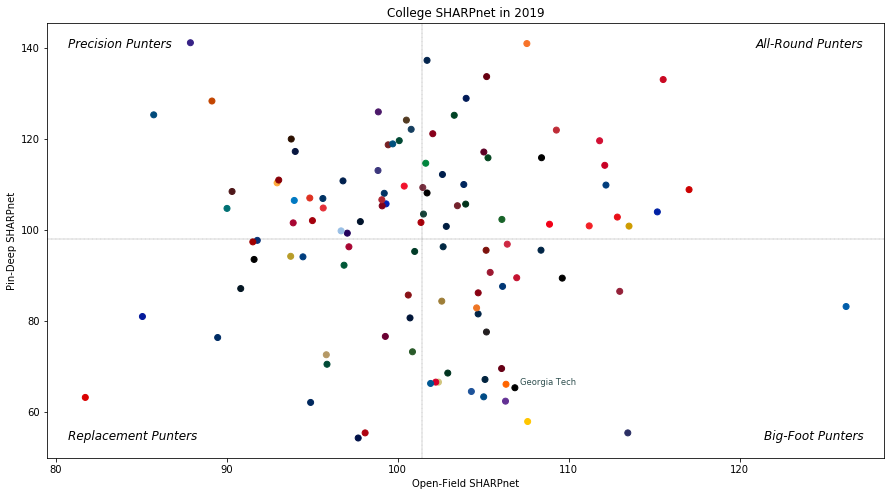

In [33]:
teams = retrieveCfbDataFile("teams", 2019)
teams[teams.conference.isna() == False].head()

def chart_sharps(season, highlight_team = None):
    team_sharp = pd.DataFrame({"Team":teams[teams.conference.isna() == False].school,"Season": season,"Color":teams[teams.conference.isna() == False].color})
    team_sharp['Total'] = team_sharp.apply(lambda x: calculate_sharp_metrics(x.Team, x.Season)[0], axis=1)
    team_sharp['Avg SHARPNet'] = team_sharp.apply(lambda x: calculate_sharp_metrics(x.Team, x.Season)[1], axis=1)
    team_sharp['Avg Pin-Deep SHARPNet'] = team_sharp.apply(lambda x: calculate_sharp_metrics(x.Team, x.Season)[2], axis=1)
    team_sharp['Avg Open-Field SHARPNet'] = team_sharp.apply(lambda x: calculate_sharp_metrics(x.Team, x.Season)[3], axis=1)
    fs, az = plt.subplots(1, figsize=(15,8))
    az.scatter(team_sharp['Avg Open-Field SHARPNet'],team_sharp['Avg Pin-Deep SHARPNet'], c = team_sharp['Color'])
    az.set_title(f"College SHARPnet in {season}")
    az.set_ylabel("Pin-Deep SHARPnet");
    az.set_xlabel("Open-Field SHARPnet");
    az.axvline(team_sharp['Avg Open-Field SHARPNet'].mean(), linestyle="--", linewidth=0.25, color="black")
    az.axhline(team_sharp['Avg Pin-Deep SHARPNet'].mean(), linestyle="--", linewidth=0.25, color="black")
    az.text(0.025, 0.95,'Precision Punters', ha='left', va='center', transform = az.transAxes, size="large", style="oblique")
    az.text(0.025, 0.05,'Replacement Punters', ha='left', va='center', transform = az.transAxes, size="large", style="oblique")
    az.text(0.975, 0.05,'Big-Foot Punters', ha='right', va='center', transform = az.transAxes, size="large", style="oblique")
    az.text(0.975, 0.95,'All-Round Punters', ha='right', va='center', transform = az.transAxes, size="large", style="oblique")
    
    if (highlight_team != None):
        dataset = team_sharp[team_sharp.Team == highlight_team][['Avg Open-Field SHARPNet','Avg Pin-Deep SHARPNet']]
        for x, y in dataset.iterrows():
            az.annotate(s=highlight_team, xy=y, xytext=(35,-5), textcoords='offset points',family='sans-serif', size="small", color='darkslategrey')
    return az

chart_sharps(2019,"Georgia Tech");

In [34]:
# Punt SR by team, YoY
team_punts = punts.copy().groupby(['Season', 'Offense'])
# print(team_punts.groups)
ratings = team_punts.apply(lambda x: 0 if (len(x) == 0) else (len(x[x.Successful == True]) / len(x)))
team_fr_szn = ratings.reset_index()
team_fr_szn.columns = ["Season",'Offense','PuntSR']
team_fr_szn

pivot = team_fr_szn.pivot_table(values='PuntSR', index='Offense', columns='Season').reset_index()
# pivot.reset_index(inplace=True)
pivot
# pivot.corr()

Season,Offense,2012,2013,2014,2015,2016,2017,2018,2019
0,Abilene Christian,NaN,0.600000,0.428571,0.428571,0.777778,0.666667,0.571429,0.538462
1,Air Force,0.636364,0.540000,0.589286,0.436364,0.590909,0.658537,0.522727,0.551724
2,Akron,0.551724,0.621212,0.552239,0.571429,0.483333,0.592593,0.466667,0.425000
3,Alabama,0.695652,0.722222,0.770833,0.576271,0.777778,0.767442,0.485714,0.407407
4,Alabama A&M,0.500000,0.250000,0.222222,0.375000,0.160000,0.500000,0.400000,NaN
5,Alabama State,NaN,0.666667,NaN,NaN,0.111111,0.777778,0.454545,0.714286
6,Albany,NaN,0.666667,NaN,0.666667,0.714286,0.500000,0.200000,0.400000
7,Alcorn State,0.600000,0.875000,0.250000,0.750000,0.400000,0.600000,0.500000,0.571429
8,Appalachian State,0.666667,0.800000,0.488889,0.562500,0.645833,0.462963,0.615385,0.625000
9,Arizona,0.666667,0.553571,0.643836,0.607843,0.568627,0.365854,0.543478,0.474576


In [35]:
# GT Punt SR
pivot[pivot.Offense == 'Georgia Tech']

Season,Offense,2012,2013,2014,2015,2016,2017,2018,2019
66,Georgia Tech,0.585366,0.589744,0.62069,0.511111,0.533333,0.78,0.741935,0.620253


In [36]:
## FG Exp Value

fg_plays = pbp_data[pbp_data.play_type.str.contains("Field Goal")]
fg_set = pd.DataFrame(columns=["Index","Offense","Season","PlayText","Yardline","Distance","Status"])
fg_set["Index"] = fg_plays.index
fg_set["Season"] = fg_set.apply(lambda x: fg_plays.year[x.Index],axis=1)
fg_set["Offense"] = fg_set.apply(lambda x: fg_plays.offense[x.Index],axis=1)
fg_set["PlayText"] = fg_set.apply(lambda x: fg_plays.play_text[x.Index],axis=1)
fg_set["Yardline"] = fg_set.apply(lambda x: 0 if (x.Index == None) else fg_plays.yard_line[x.Index],axis=1)
fg_set["Distance"] = (50 - (fg_set.Yardline % 50)) + 17

def verify_fg_status(play_type):
    if ("Good" in play_type):
        return "Good"
    elif ("Blocked" in play_type):
        return "Blocked"
    elif ("Missed" in play_type):
        return "Missed"
    else:
        return "Unknown"

fg_set["Status"] = fg_set.apply(lambda x: verify_fg_status(fg_plays.play_type[x.Index].replace("Field Goal ","")),axis=1)
fg_set.head(15)

,Index,Offense,Season,PlayText,Yardline,Distance,Status
0,218,Connecticut,2012,Chad Christen 36 yard field goal GOOD.,81,36,Good
1,247,Connecticut,2012,Chad Christen 47 yard field goal GOOD.,70,47,Good
2,316,Connecticut,2012,Chad Christen 19 yard field goal GOOD.,98,19,Good
3,362,Idaho,2012,Trey Farquhar 27 yard field goal GOOD.,90,27,Good
4,373,Eastern Washington,2012,Jimmy Pavel 34 yard field goal GOOD.,83,34,Good
5,446,Eastern Washington,2012,Jimmy Pavel 23 yard field goal GOOD.,95,22,Good
6,525,Sacramento State,2012,Edward Ruhnke 37 yard field goal MISSED.,79,38,Missed
7,588,Sacramento State,2012,Edgar Castaneda 32 yard field goal GOOD.,85,32,Good
8,624,Sacramento State,2012,Edgar Castaneda 25 yard field goal GOOD.,91,26,Good
9,734,South Carolina,2012,Adam Yates 20 yard field goal GOOD.,97,20,Good


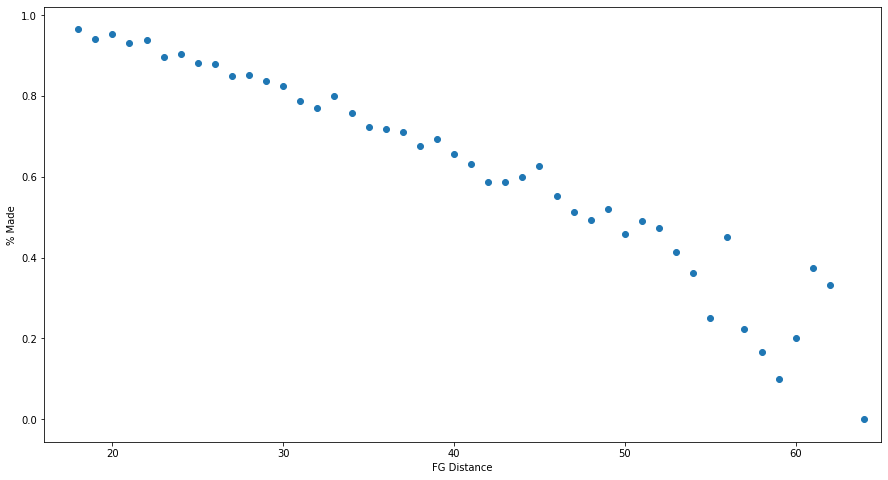

In [37]:
X_fg = fg_set.groupby('Distance').apply(lambda y: y.Distance).drop_duplicates()[:,np.newaxis]
y_fg = fg_set.groupby('Distance').apply(lambda x: 0 if (len(x) == 0) else (len(x[x.Status == 'Good']) / len(x)))[:,np.newaxis]
fig, ax = plt.subplots(1, 1,figsize=(15,8))
ax.scatter(X_fg, y_fg);
# ax.set_ylim((0, 55))
ax.set_xlim((min(X_fg)-2, 65)) # modern record is 65 yards from KState in 98
ax.set_ylabel("% Made");
ax.set_xlabel("FG Distance");

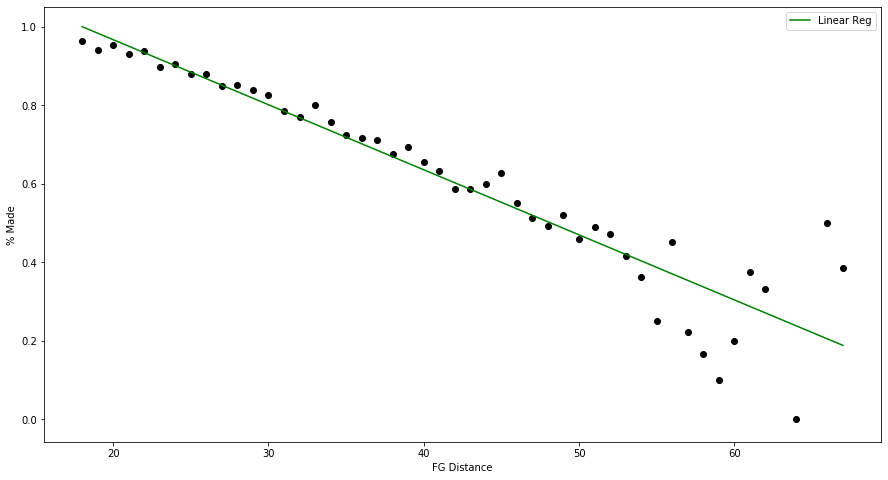

In [38]:
lin_fg = LinearRegression()  
lin_fg.fit(X_fg, y_fg) 

poly_fg = PolynomialFeatures(degree = 2) 
X_poly_fg = poly.fit_transform(X_fg)
poly_fg.fit(X_poly_fg, y_fg) 
lin2_fg = LinearRegression() 
lin2_fg.fit(X_poly_fg, y_fg) 

fig, ax = plt.subplots(1, 1,figsize=(15,8))
# Visualising the Linear Regression results 
ax.scatter(X_fg, y_fg, color = 'black') 
# ax.set_ylim((0, 55))
# ax.set_xlim((0, 75))
ax.set_ylabel("% Made");
ax.set_xlabel("FG Distance");
ax.plot(X_fg, lin_fg.predict(X_fg), color = 'g', label="Linear Reg") 
# ax.plot(X_fg, lin2_fg.predict(X_poly_fg), color = 'b', label="Polynomial Reg") 
ax.legend();

In [39]:
exp_fg_value = pd.DataFrame(columns=["Distance","Accuracy"])
exp_fg_value.Distance = fg_set.groupby('Distance').apply(lambda y: y.Distance).drop_duplicates()
exp_fg_value.Accuracy = lin_fg.predict(exp_fg_value.Distance[:,np.newaxis])#fg_set.groupby('Distance').apply(lambda x: 0 if (len(x) == 0) else (len(x[x.Status == 'Good']) / len(x))).to_numpy()
exp_fg_value['ExpFGValue'] = exp_fg_value.apply(lambda x: x.Accuracy * 3.0, axis=1)
exp_fg_value.reset_index(drop=True, inplace=True)
exp_fg_value.set_index(keys=['Distance'])
exp_fg_value.to_csv('results/fg_sr.csv', index=False, sep=",") # only uncomment to save the file
exp_fg_value

,Distance,Accuracy,ExpFGValue
0,18,1.000696,3.002089
1,19,0.984118,2.952355
2,20,0.967541,2.902622
3,21,0.950963,2.852889
4,22,0.934385,2.803156
5,23,0.917808,2.753423
6,24,0.901230,2.703690
7,25,0.884652,2.653956
8,26,0.868074,2.604223
9,27,0.851497,2.554490


In [40]:
# FG SR by team, YoY
fgs = fg_set.copy()
exp_fg = pd.read_csv("results/fg_sr.csv", encoding="latin-1")
def assign_fg_exp_val(distance):
    return exp_fg[exp_fg.Distance == distance].ExpFGValue.to_list()[0]
def generate_actual_val(x):
    if (x.Status == 'Good'):
        return 3
    else:
        return 0

fgs['ExpFGValue'] = fgs.apply(lambda x: assign_fg_exp_val(x.Distance), axis=1)
fgs['NetFGValue'] = fgs.apply(lambda x: generate_actual_val(x) - x.ExpFGValue, axis=1)

team_fg = fgs.copy().groupby(['Season', 'Offense'])
# print(team_punts.groups)
ratings_fg = team_fg.apply(lambda x: x.NetFGValue.mean())
team_fr_szn_fg = ratings_fg.reset_index()
team_fr_szn_fg.columns = ["Season",'Offense','FGSR']
team_fr_szn_fg

pivot_fg = team_fr_szn_fg.pivot_table(values='FGSR', index='Offense', columns='Season').reset_index()
# pivot.reset_index(inplace=True)
pivot_fg
# pivot.corr()

Season,Offense,2012,2013,2014,2015,2016,2017,2018,2019
0,Abilene Christian,NaN,0.097378,0.681743,-2.256091,-2.156624,-0.407958,1.092042,1.241241
1,Air Force,-1.031224,0.722318,0.343757,0.436292,0.307691,0.304093,0.117670,0.847520
2,Akron,0.155542,-0.416283,-0.072846,-0.259270,0.489267,-0.702564,0.212824,-0.361036
3,Alabama,0.245062,-0.059921,-0.261097,-0.085392,-0.037553,0.050060,-0.147446,-0.220172
4,Alabama A&M,NaN,-2.156624,NaN,0.495243,-2.057158,-2.803156,NaN,NaN
5,Alabama State,NaN,NaN,NaN,NaN,NaN,NaN,-1.758759,-0.956624
6,Albany,NaN,-0.482558,NaN,NaN,-2.156624,0.942842,NaN,-1.957692
7,Alcorn State,-2.256091,NaN,NaN,-2.156624,-0.333359,1.539640,NaN,-0.308492
8,Appalachian State,-0.073736,-0.209026,-0.523469,0.810261,-0.179901,0.092804,0.036744,-0.159940
9,Arizona,-0.300317,-0.259270,-0.156830,0.485382,0.238360,0.069607,0.063163,-0.245644


In [41]:
pivot_fg[pivot_fg.Offense == 'Georgia Tech']

Season,Offense,2012,2013,2014,2015,2016,2017,2018,2019
66,Georgia Tech,-0.397891,0.126883,-0.295662,0.186502,0.412442,-0.205824,0.188698,-0.957025


In [42]:
# 2019 Net FG Value per Kick rankings 
pivot_fg.dropna()[['Offense',2019]].sort_values(by=2019,ascending=False)

Season,Offense,2019
125,Nicholls,1.042308
133,Northern Arizona,1.017442
224,Western Carolina,0.992575
202,UC Davis,0.893109
1,Air Force,0.847520
221,Washington State,0.641312
102,Memphis,0.629670
184,TCU,0.570476
214,Vanderbilt,0.529875
212,Utah State,0.513406


In [43]:
# ST SP+ (circa 2016): 44% place-kicking, 24% punting, 14% kickoffs, 14% kick returns, 3% punt returns.